# **Biblioteki**

In [4]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.3/95.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.4 MB/s eta 0:00:00


In [5]:
!pip install pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=b756c4cf54b0550333f0c20fa19e990e7ab1d4b6ccc77f7d3a628bd91e205b98
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import select_features
import random as random
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import pingouin as pg
from scipy import stats

# **Wczytanie danych**

Dane do zadania pochodzą z biblioteki tsfresh:

https://tsfresh.readthedocs.io/en/latest/text/quick_start.html

Zadanie polega na klasyfikacji szeregów czasowych.

Dane:

Danych jest 6 szeregów czasowych pochodzących z 6 różnych czujników robota, ID czyli identyfikator próbki oraz czas zarejestrowania sygnału.

etykiety: 0 - robot sprawny, 1 - robot uległ awarii.

 Dla każdej próbki należy dokonać klasyfikacji:

In [7]:
# Wczytanie danych:
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [8]:
timeseries.head()

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0


**Rozmiar zbioru danych:**

In [9]:
timeseries.shape

(1320, 8)

**Sprawdzenie liczby próbek:**

In [10]:
timeseries['id'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88])

Mamy 88 próbek co oznacza, że musimy dokonać dokładniej selekcji wygenerowanych cech. Zbyt wiele atrybutów spowoduje nadmierne dopasowanie modeli.

# **Narysowanie wykresów**

Poniżej narysowane zostały przykładowe wykresy zarejestrowanych szeregów dla dwóch próbek (przebieg bez awarii i z awarią).

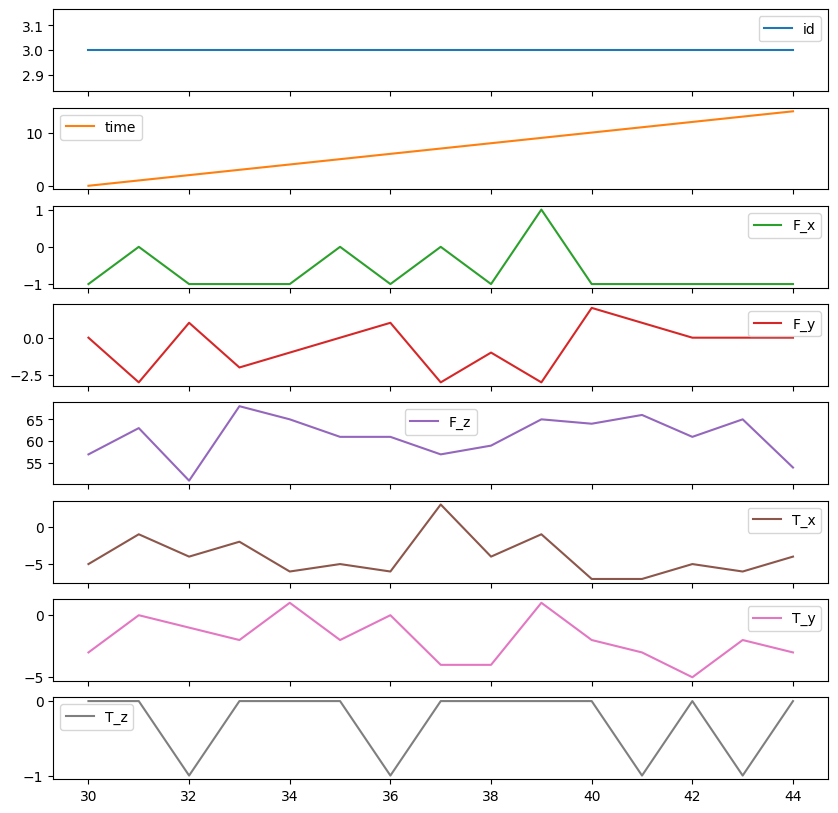

In [11]:
# odczyty ze sprawnego urządzenia
timeseries[timeseries['id'] == 3].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

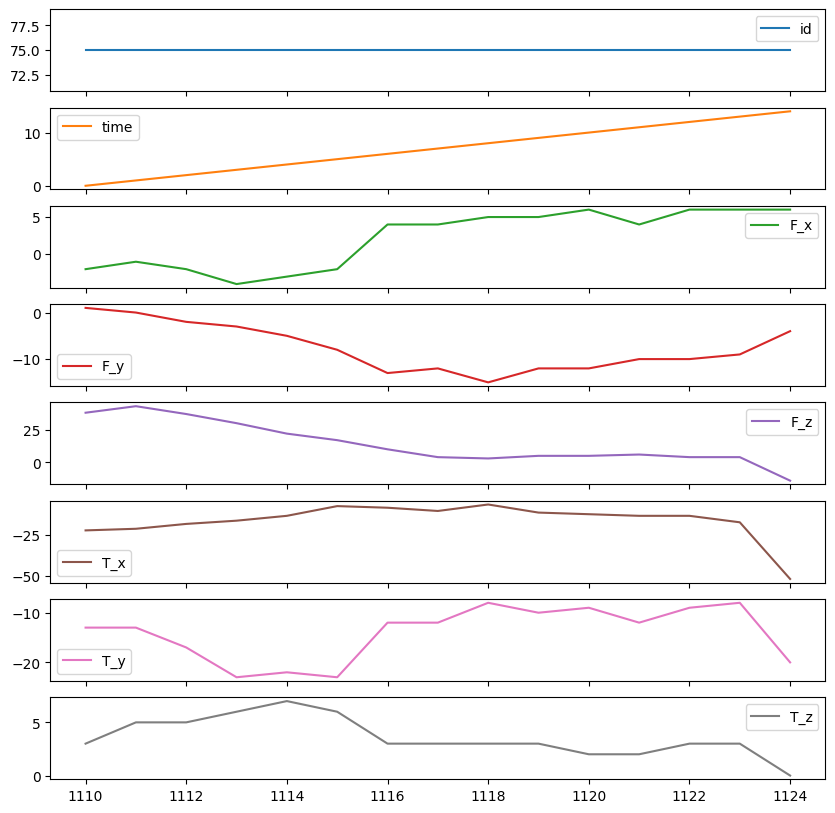

In [12]:
# odczyty z urządzenia, które uległo awarii
timeseries[timeseries['id'] == 75].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

# **Ekstrakcja cech**



W tym zadaniu rozważamy przypadek, w którym wygenerowane zostaną wszystkie możliwe cechy (z biblioteki tsfresh). Takie podejście jest stosowane kiedy nie ma pewności jakie cechy są poszukiwane, więc sprawdzane są wszystkie możliwe opcje.

**Lista cech:**

https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

Z wykorzystaniem biblioteki tsfresh wygenerujemy wszystkie możliwe cechy dla analizowanych szeregów czasowych. Podczas ekstrakcji należy pamiętać o dwóch rzeczach:

1) nie wszystkie cechy są istotne - tak naprawdę większość z nich nie jest istotna,

2) część cech nie zostanie wyznaczona (NaN)  - otrzymujemy NaN gdy wartość cechy dla danego szeregu jest zbyt mała.


**Ekstrakcja cech:**

In [ ]:
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

Feature Extraction:  24%|██▍       | 129/528 [00:16<00:46,  8.59it/s]

In [57]:
extracted_features.head()

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,0.974315,1.288185,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143


Teraz należy zastąpić wszystkie NaN zerami, ponieważ jest to niezbędne do zastosowania algorytmu selekcji cech.

In [ ]:
# Zastąpienie NaN - zerami

data = impute(extracted_features)
data.isna().sum()

# **Selekcja cech**

**Dlaczego dokonujemy selekcji cech ?**

1) tzw. przekleństwo nadmiernego dopasowania - dane testowe zostaną idealnie dopasowane ale nie będzie to miało przełożenia na inne (nowe) próbki (model będzie trudny do generalizacji),

2) gdy danych jest zbyt wiele niepotrzebnie komplikujemy model (tzw. brzytwa Ockhama - im prostszy model tym lepiej - generalnie jeżeli zmniejszenie liczby cech nie pogarsza znacząco predykcji modelu to znaczy, że należy dokonać ich selekcji), prostota modelu pozwala oszczędzić czas i zmniejszyć potrzebną moc obliczeniową, a także ułatwić jego interpretację,  

3) jeżeli na wejściu będą dane niskiej jakości, to na wyjściu również otrzymamy dane niskiej jakości.

Ponadto należy uważać na mocno skorelowane cechy, które nie wnoszą znaczących, nowych informacji. W zależności od specyfiki problemu, danych oraz modelu mogą one wpływać negatywnie na wyniki** np. mogą maskować interakcje między obiektami lub pogarszać działanie modelu. Jeżeli skorelowane cechy mają w sobie jakąś "szkodliwą" informację, która pogarsza predykcje modelu to mając np. 2 skorelowane cechy zwiększamy siłę tej "szkodliwej" informacji dwukrotnie. Tak samo należy mieć na uwadze, że jeśli jedna konkretna cecha jest silnie skorelowana (bardzo wysoki wsp. korelacji) z wyjściem modelu, to w niektórych wypadkach może dojść do nadmiernego dopasowania, a wyniki mogą być powtarzalne tylko w pewnym, konkretnym przypadku.  

** mogą mieć negatywny wpływ, ale nie muszą czasami wykorzystuje się cechy, które są ze sobą skorelowane.

Trzeba pamiętać również o ocenie czy korelacja ma sens logiczny, a także o tym, że współczynnik korelacji może być różnie interpretowany w zależności od rozważanego zagadnienia (np. w medycynie nawet wydawałoby się niska wartość współczynnika korelacji może być bardzo istotna).

Selekcja cech jest procesem niezwykle istotnym, ale i bardzo złożonym. Tak naprawdę aby prawidłowo wybrać cechy trzeba posiadać odpowiednią wiedzę dotyczącą danych oraz badanego problemu. Algorytmy wykorzystywane do selekcji cech są pomocą w odpowiednim wyborze, ale w rzeczywistości należy być krytycznym wobec otrzymanych wyników.


Istnieje wiele metod selekcji cech, ale większość z nich możemy podzielić na 3 grupy:

**Metody filtrujące (filter methods)**: wykorzystują miary statystyczne do oceny związku cechy ze zmienną docelową i są zazwyczaj niezależne od modeli (np. korelacja).

**Metody opakowujące (wrapper methods)**: najczęściej wykorzystują predykcyjną moc modelu do oceny kombinacji cech (np. rekurencyjna eliminacja cech).

**Metody wbudowane (embedded methods)**: dokonują selekcji cech podczas procesu trenowania modelu i są specyficzne dla danego modelu.

UWAGA! : NIE ISTNIEJE JEDNA KONKRETNA METODA SELEKCJI CECH, DOBÓR METODY ZALŻY OD SPECYFIKI PROBLEMU, CZASEM NALEŻY ZASTOSOWAĆ KILKA Z NICH. ZAWSZE NALEŻY KRYTYCZNIE PRZYJRZEĆ SIĘ OTRZYMANYM WYNIKOM.



**Selekcja z wykorzystaniem biblioteki tsfresh.**

Selekcja cech z wykorzystaniem wbudowanej funkcji biblioteki tsfresh (algorytm FRESH) - polega na badaniu wpływu poszczególnych cech na wyjście modelu.

Algorytm FRESH szacuje jak poszczególne zmienne wpływają na wyjście.

In [ ]:
print(y)

In [ ]:
features_filtered = select_features(extracted_features, y)

In [ ]:
features_filtered

W wyniku wartościowania znacząco zmniejszyliśmy zbiór danych, niestety nadal jest on jednak zbyt duży. Wykorzystanie tego algorytmu może być traktowane jako pierwszy element eliminacji.

UWAGA!: Algorytm FRESH może być pomocny w wartościowaniu cech, ale trudno jest uzasadnić dokonywane przez niego wybory. Dlatego wykorzystamy teraz przykładową metodę RFE (rekurencyjnej eliminacji cech) do oceny działania tego algorytmu.

Jak działa metoda RFE?

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

Jest to metoda przyrostowego podejścia wyboru cech, w którym cechy są stopniowo eliminowane, tworząc coraz mniejsze zbiory aż do osiągnięcia liczby cech zdefiniowanej na początku. Jest to selekcja wsteczna - zaczynamy od całego zbioru i stopniowo zmniejszamy podzbiory.

W przypadku selekcji w przód cechy są dodawane do zbioru aż do osiągnięcia minimalnej liczby cech lub spełnienia innego kryterium zatrzymania np. chcemy mieć taka liczbę cech, która pozwoli otrzymać precyzję na poziomie powyżej 90%.

Metoda RFE wymaga zdefiniowania konkretnego estymatora, w naszym wypadku będzie to RandomForestClassifier. Na tym etapie wykorzystamy RFE jedynie do oceny działania algorytmu FRESH.

Na początku wylosujemy 10 cech, które algorytm uznał za istotne i 10, które odrzucił.


In [ ]:
sel_feat_10 = random.sample(range(len(features_filtered.columns)), 10)      # 10 losowych cech istotnych wdg. algorytmu FRESH
sel_feat_10_val = features_filtered.iloc[:, sel_feat_10].values
unsel_feat_10 = list(set(extracted_features.columns).difference(set(features_filtered.columns))) # 10 losowych cech nieistotnych wdg. algorytmu FRESH
unsel_feat_10 = random.sample(unsel_feat_10, 10)
unsel_feat_10_idx = [idx for (idx, val) in enumerate (extracted_features.columns) if val in unsel_feat_10]
unsel_feat_10_val = extracted_features.iloc[:, unsel_feat_10_idx].values
mixed_X = np.hstack([sel_feat_10_val, unsel_feat_10_val])

Teraz ustalimy istotność 20 wylosowanych cech z wykorzystaniem metody RFE.

In [ ]:
# RFE - estymator las losowy

# skalowanie danych
scaler = StandardScaler()
mixed_X_scaled= scaler.fit_transform(mixed_X)

# RFE
rf_classifier = RandomForestClassifier(random_state=42)
rfe = RFE(estimator = rf_classifier, n_features_to_select = 1)  # n_features_to_select = 1 umożliwia utworzenie rankingu wszystkich cech podanych na wejściu
rfe.fit(mixed_X_scaled,y)
rfe.ranking_

In [ ]:
features_selected_name = list(set(extracted_features.columns))

sel_feat = [name for idx,name in enumerate(features_selected_name) if idx in sel_feat_10]
features_name = sel_feat + unsel_feat_10
importance = ['istotna'] * 10 + ['nieistotna'] * 10
print(importance)

In [ ]:
print(mixed_X_scaled)

In [ ]:

df_RFE = pd.DataFrame({'cecha':features_name, 'istotność (FRESH)': importance, 'ranking':rfe.ranking_ })
df_RFE.sort_values(by = 'ranking')

**Proszę ocenić działanie algorytmu FRESH.**


Czy 10 cech wylosowanych ze zbioru cech istotnych według algorytmu FRESH jest na pierwszych 10 miejscach według algorytmu RFE?

Jeśli nie, to czy różnice są duże ?

Czy w takim razie Państwa zdaniem selekcja jest dobra? Czy możemy zaakceptować takie różnice

**ODP:**

Wyniki nie pokrywają się idealnie, różnice są jednak akceptowalne - wyniki w dużej mierze są spójne. Aby mieć pewność można kilkukrotnie wylosować cechy i sprawdzić czy nie pojawiają się znaczące różnice. Należy jednak pamiętać o tym, że algorytm FRESH uznał ponad 600 cech za istotne, a w naszym wypadku żeby nie doszło do nadmiernego dopasowania (w przypadku tak małej liczby klasyfikowanych przypadków) potrzebujemy tylko kilku z nich więc możemy uznać, że wstępna selekcja jest prawidłowa i żadne istotne informacje nie zostały utracone. W sytuacji kiedy podejrzewamy, że selekcja wstępna nie przebiegła prawidłowo możemy z niej zrezygnować i skorzystać z innej metody wartościowania cech (dobranej w zależności od liczby danych - im danych jest mniej tym łatwiej dokonać selekcji).

Algorytm FRESH jest właściwie pozbawiony parametrów oznacza to, że najlepszą metodą wpływania na otrzymane wyniki jest sterowanie liczbą i jakością wprowadzanych do niego cech. Musimy mieć na uwadze, że jeżeli tak jak w naszym przypadku decydujemy się wygenerować wszystkie możliwe cechy to większość z nich nie będzie użyteczna, a zastosowanie algorytmu FRESH jest jak najbardziej wskazane.

Stosując algorytm FRESH możemy również zdefiniować jaka część cech ma zostać odrzucona (parametr: fdr_level), dzięki temu możemy regulować liczbę cech odrzuconych, jest to korzystne w sytuacji kiedy mamy bardzo wiele cech i chcemy znacząco zmniejszyć zbiór danych.

features_filtered_2 = select_features(extracted_features, y, fdr_level = x)

fdr_level domyślnie ustawiony jest na 0.05

Im mniejszy fdr_level tym selekcja jest większa (otrzymujemy mniejszy zbiór).

**Zadanie**

Proszę ustawić parametr fdr_level na 0.0001 i przy pomocy metody RFE sprawdzić czy prawie dwukrotne zmniejszenie zbioru daje akceptowalne wyniki.


In [31]:
sel_features = select_features(extracted_features, y, fdr_level=0.0001)

sel_features.head()

,F_x__value_count__value_-1,F_x__abs_energy,F_x__root_mean_square,T_y__absolute_maximum,F_x__mean_n_absolute_max__number_of_maxima_7,F_x__range_count__max_1__min_-1,F_y__abs_energy,F_y__root_mean_square,F_y__mean_n_absolute_max__number_of_maxima_7,T_y__variance,...,"T_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","F_z__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","F_y__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",T_x__autocorrelation__lag_1,T_x__partial_autocorrelation__lag_1,F_y__value_count__value_0,"F_y__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.0","T_z__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.4","F_z__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)","F_z__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2"
1,14.0,14.0,0.966092,1.0,1.000000,15.0,13.0,0.930949,1.000000,0.222222,...,0.571429,1.0,0.214286,-0.093407,-0.093407,2.0,0.000000,0.0,105.733481,0.640000
2,7.0,25.0,1.290994,5.0,1.571429,13.0,76.0,2.250926,3.000000,4.222222,...,0.857143,-3.0,1.750000,0.005582,0.005582,0.0,1.555556,0.0,105.819132,2.000000
3,11.0,12.0,0.894427,5.0,1.000000,14.0,40.0,1.632993,2.142857,3.128889,...,1.333333,-2.0,1.000000,-0.123626,-0.123626,5.0,1.833333,0.0,104.165366,5.000000
4,5.0,16.0,1.032796,6.0,1.285714,10.0,60.0,2.000000,2.428571,7.128889,...,1.000000,4.0,2.000000,0.137722,0.137722,1.0,2.181818,0.0,108.888548,0.888889
5,9.0,17.0,1.064581,5.0,1.285714,13.0,46.0,1.751190,2.285714,4.160000,...,0.800000,6.0,2.166667,-0.507519,-0.507519,3.0,1.250000,0.0,104.386075,0.000000


In [32]:
# Rozwiązanie
scaler = StandardScaler()
features_filtered_scaled= scaler.fit_transform(sel_features)

# RFE
rf_classifier = RandomForestClassifier(random_state=42)
rfe = RFE(estimator = rf_classifier, n_features_to_select = 1)

rfe.fit(features_filtered_scaled, y)


RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=1)

In [33]:
sel_features.columns

Index(['F_x__value_count__value_-1', 'F_x__abs_energy',
       'F_x__root_mean_square', 'T_y__absolute_maximum',
       'F_x__mean_n_absolute_max__number_of_maxima_7',
       'F_x__range_count__max_1__min_-1', 'F_y__abs_energy',
       'F_y__root_mean_square', 'F_y__mean_n_absolute_max__number_of_maxima_7',
       'T_y__variance',
       ...
       'T_y__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'F_z__agg_linear_trend__attr_"slope"__chunk_len_10__f_agg_"max"',
       'F_y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'T_x__autocorrelation__lag_1', 'T_x__partial_autocorrelation__lag_1',
       'F_y__value_count__value_0',
       'F_y__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'T_z__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'F_z__cwt_coefficients__coeff_14__w_10__widths_(2, 5, 10, 20)',
       'F_z__change_quantiles__f_agg_"var"__isabs_True__qh_0.6__ql_0.2'],
      dtype='object', length=

In [34]:
rfe.ranking_

array([360,   2,   1,   5,   3,  15,   6,   4,  11,  14,   9,  17,   8,
        10,  19,  12,  16,  20,  43,  22,  18,  21,  13,   7,  48,  78,
        47,  91,  52,  51,  56,  57,  59,  55,  63,  66, 128, 119,  67,
       114,  70, 134,  69,  74, 116,  73, 127,  79,  81,  23,  85,  88,
        90,  93,  96,  95,  99, 102, 104, 106, 105, 110, 103, 117, 113,
       123, 130, 131, 129, 138, 139, 142, 144, 145, 148, 150, 194, 151,
       154, 156, 158, 159, 190, 162, 157, 155, 168, 170, 172, 171, 169,
       178, 180, 182, 184, 186, 188, 192, 195, 193, 199, 202, 204, 206,
       208, 210, 212, 214, 216, 213, 220, 221, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       259, 262, 264, 266, 268, 270, 271, 333, 311, 274, 276, 278, 280,
       282, 284, 286, 287, 290, 292, 294, 296, 298, 300, 301, 303, 305,
       308, 312, 314, 316, 318, 307, 321, 324, 326, 328, 330, 334, 336,
       338, 340, 341, 344, 346, 348, 350, 352, 353, 356, 358, 36

In [35]:
print(len(sel_features.columns), len(rfe.ranking_))

375 375


In [36]:
df_RFE = pd.DataFrame({'cecha':list(sel_features.columns), 'ranking':rfe.ranking_ })
df_RFE.sort_values(by = 'ranking')

,cecha,ranking
2,F_x__root_mean_square,1
1,F_x__abs_energy,2
4,F_x__mean_n_absolute_max__number_of_maxima_7,3
7,F_y__root_mean_square,4
3,T_y__absolute_maximum,5
...,...,...
188,"T_x__change_quantiles__f_agg_""mean""__isabs_Tru...",371
185,"T_y__change_quantiles__f_agg_""mean""__isabs_Tru...",372
374,"F_z__change_quantiles__f_agg_""var""__isabs_True...",373
186,T_y__partial_autocorrelation__lag_1,374


**Ocena selekcji:**

**ODP:**

W tym momencie początkowy zbiór danych został zmniejszony ponad 10 - krotnie, możemy więc uznać, że wstępna selekcja została zakończona. Możemy teraz wykorzystać wiele metod głębszej selekcji, ale ponieważ nasz zbiór danych nadal jest bardzo duży w stosunku do liczby klasyfikowanych próbek to wykorzystamy współczynnik korelacji Spearmana (wartości bezwzględne tego wsp. pomiędzy danymi wejściowymi a wyjściem y). Korzystając z tej metody należy jednak uważać, ponieważ może dojść do sytuacji, że model zostanie nadmiernie dopasowany - dlatego bezwzględnie należy ocenić czy cechy, które otrzymaliśmy są logiczne, a wyniki powtarzalne w ogólnym przypadku (czy zachodzi uogólnienie). Ponadto ta metoda może nie sprawdzić się do każdego typu danych np. w przypadku danych medycznych mogą zostać utracone istotne informacje.

** Przypomnienie: macierz korelacji Spearmana opiera się na współczynnikach rangowych i jest używana, gdy nie można założyć normalności rozkładów analizowanych zmiennych lub gdy związki między zmiennymi nie są liniowe.


In [37]:
# Funkcja służy do oceny wsp. korelacji - type_corr = 's' korelacja Spearmana,  type_corr = 'p' korelacja Pearsona

features_filtered_2 = select_features(extracted_features, y, fdr_level = 0.0001)

def cor_selector(X, y,num_feats, type_corr):
    cor_list = []
    feature_name = X.columns.tolist()

    if type_corr == 's':
    # wyznaczenie korelacji pomiędzy danymi wejściowymi a y
      for i in X.columns.tolist():
          cor, p = stats.spearmanr(X[i],y)          # Spearmana
          cor_list.append(cor)
    elif type_corr == 'p':
    # wyznaczenie korelacji pomiędzy danymi wejściowymi a y
      for i in X.columns.tolist():
          cor = np.corrcoef(X[i], y)[0, 1]        # Persona
          cor_list.append(cor)

      # zamiana wartości NaN na 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
      # przygotowanie listy cech
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
      # selekcja cech
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


# wybór 30 cech

X = features_filtered_2
num_feats = 30

cor_support, cor_feature = cor_selector(X, y,num_feats, type_corr = 's')
print(str(len(cor_feature)), 'selected features')

cor_feature

30 selected features


['T_y__fft_coefficient__attr_"abs"__coeff_2',
 'T_x__fft_coefficient__attr_"abs"__coeff_1',
 'T_x__standard_deviation',
 'T_x__variance',
 'F_x__ratio_value_number_to_time_series_length',
 'F_x__standard_deviation',
 'F_x__variance',
 'F_z__variance',
 'F_z__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"var"',
 'F_z__standard_deviation',
 'T_y__mean_n_absolute_max__number_of_maxima_7',
 'T_y__root_mean_square',
 'T_y__abs_energy',
 'T_y__fft_coefficient__attr_"abs"__coeff_1',
 'F_x__absolute_maximum',
 'F_x__fft_coefficient__attr_"abs"__coeff_1',
 'T_x__absolute_maximum',
 'F_y__absolute_maximum',
 'T_y__standard_deviation',
 'T_y__variance',
 'F_y__mean_n_absolute_max__number_of_maxima_7',
 'F_y__root_mean_square',
 'F_y__abs_energy',
 'F_x__range_count__max_1__min_-1',
 'F_x__mean_n_absolute_max__number_of_maxima_7',
 'T_y__absolute_maximum',
 'F_x__root_mean_square',
 'F_x__abs_energy',
 'F_x__variance_larger_than_standard_deviation',
 'F_x__value_count__value_-1']

In [38]:
# przygotowanie zbioru danych w oparciu o wybrane cechy
df_feat = features_filtered_2[cor_feature]

30 cech to dalej zbyt wiele dlatego wykorzystamy funkcję feature_importances_ dla lasu losowego do ostatecznego zbadania istotności cech i na podstawie otrzymanych wyników przeprowadzimy klasyfikację. Ocenimy również korelację pomiędzy wybranymi zmiennymi.

Do określenia wartości cech wykorzystamy: feature_importances_ dla lasu losowego - cechy są wartościowane na podstawie średniej i odchylenia standardowego akumulacji zanieczyszczeń w drzewach.

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html





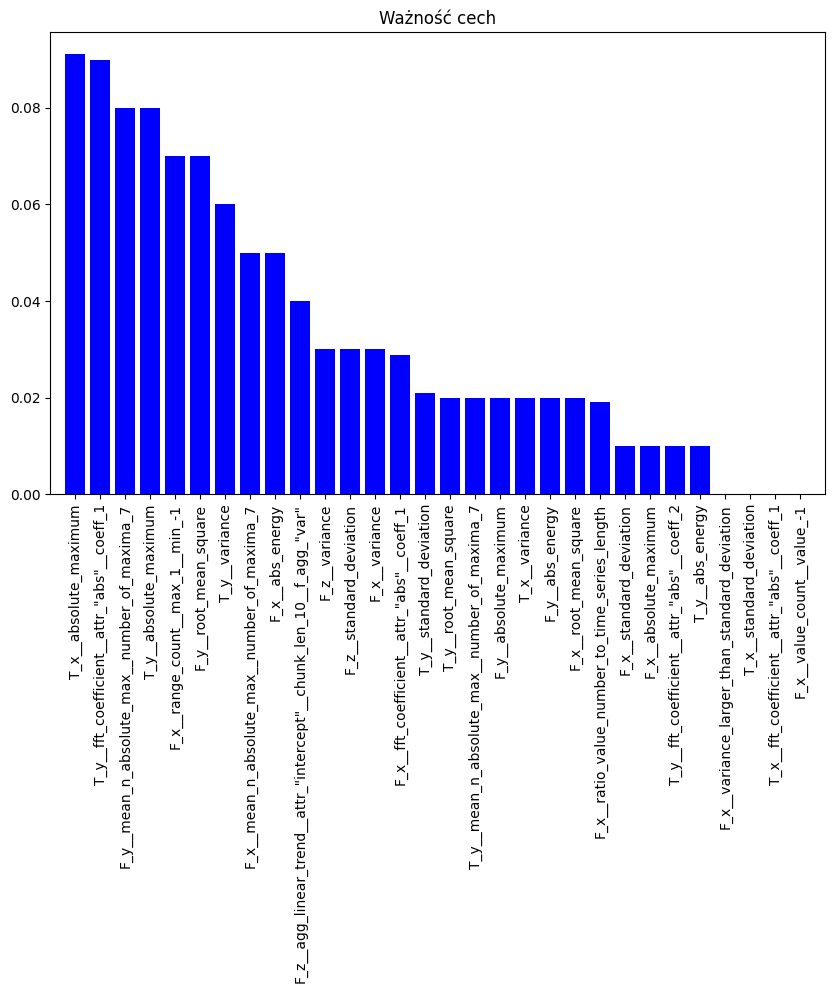

In [39]:
X = df_feat
y = y

# Podział na zestaw treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wczytanie lasu losowego i przeprowadzenie klasyfikacji na danych ze standaryzacją
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)
importances = rf_classifier.feature_importances_

# Wizualizacja ważności cech
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Ważność cech")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train_scaled.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()

# utworzenie df z istotnymi cechami
imp = pd.DataFrame({"importance": importances, "names": df_feat.columns})


Analizując wykres możemy zdecydować ile cech należy uwzględnić - na początku zdecydujmy się na 7 cech.

In [40]:
features_1 = []
numb_of_feat = 7

# wybór 4 najlepszych cech
most_important_features = imp.nlargest(numb_of_feat, 'importance')
features_1.append(most_important_features["names"])

# utworzenie df
df_features_1 = df_feat[most_important_features["names"]]


**Analiza korelacji**

H0: Nie ma zależności pomiędzy zmiennymi.

H1: Jest zależność pomiędzy zmiennymi.

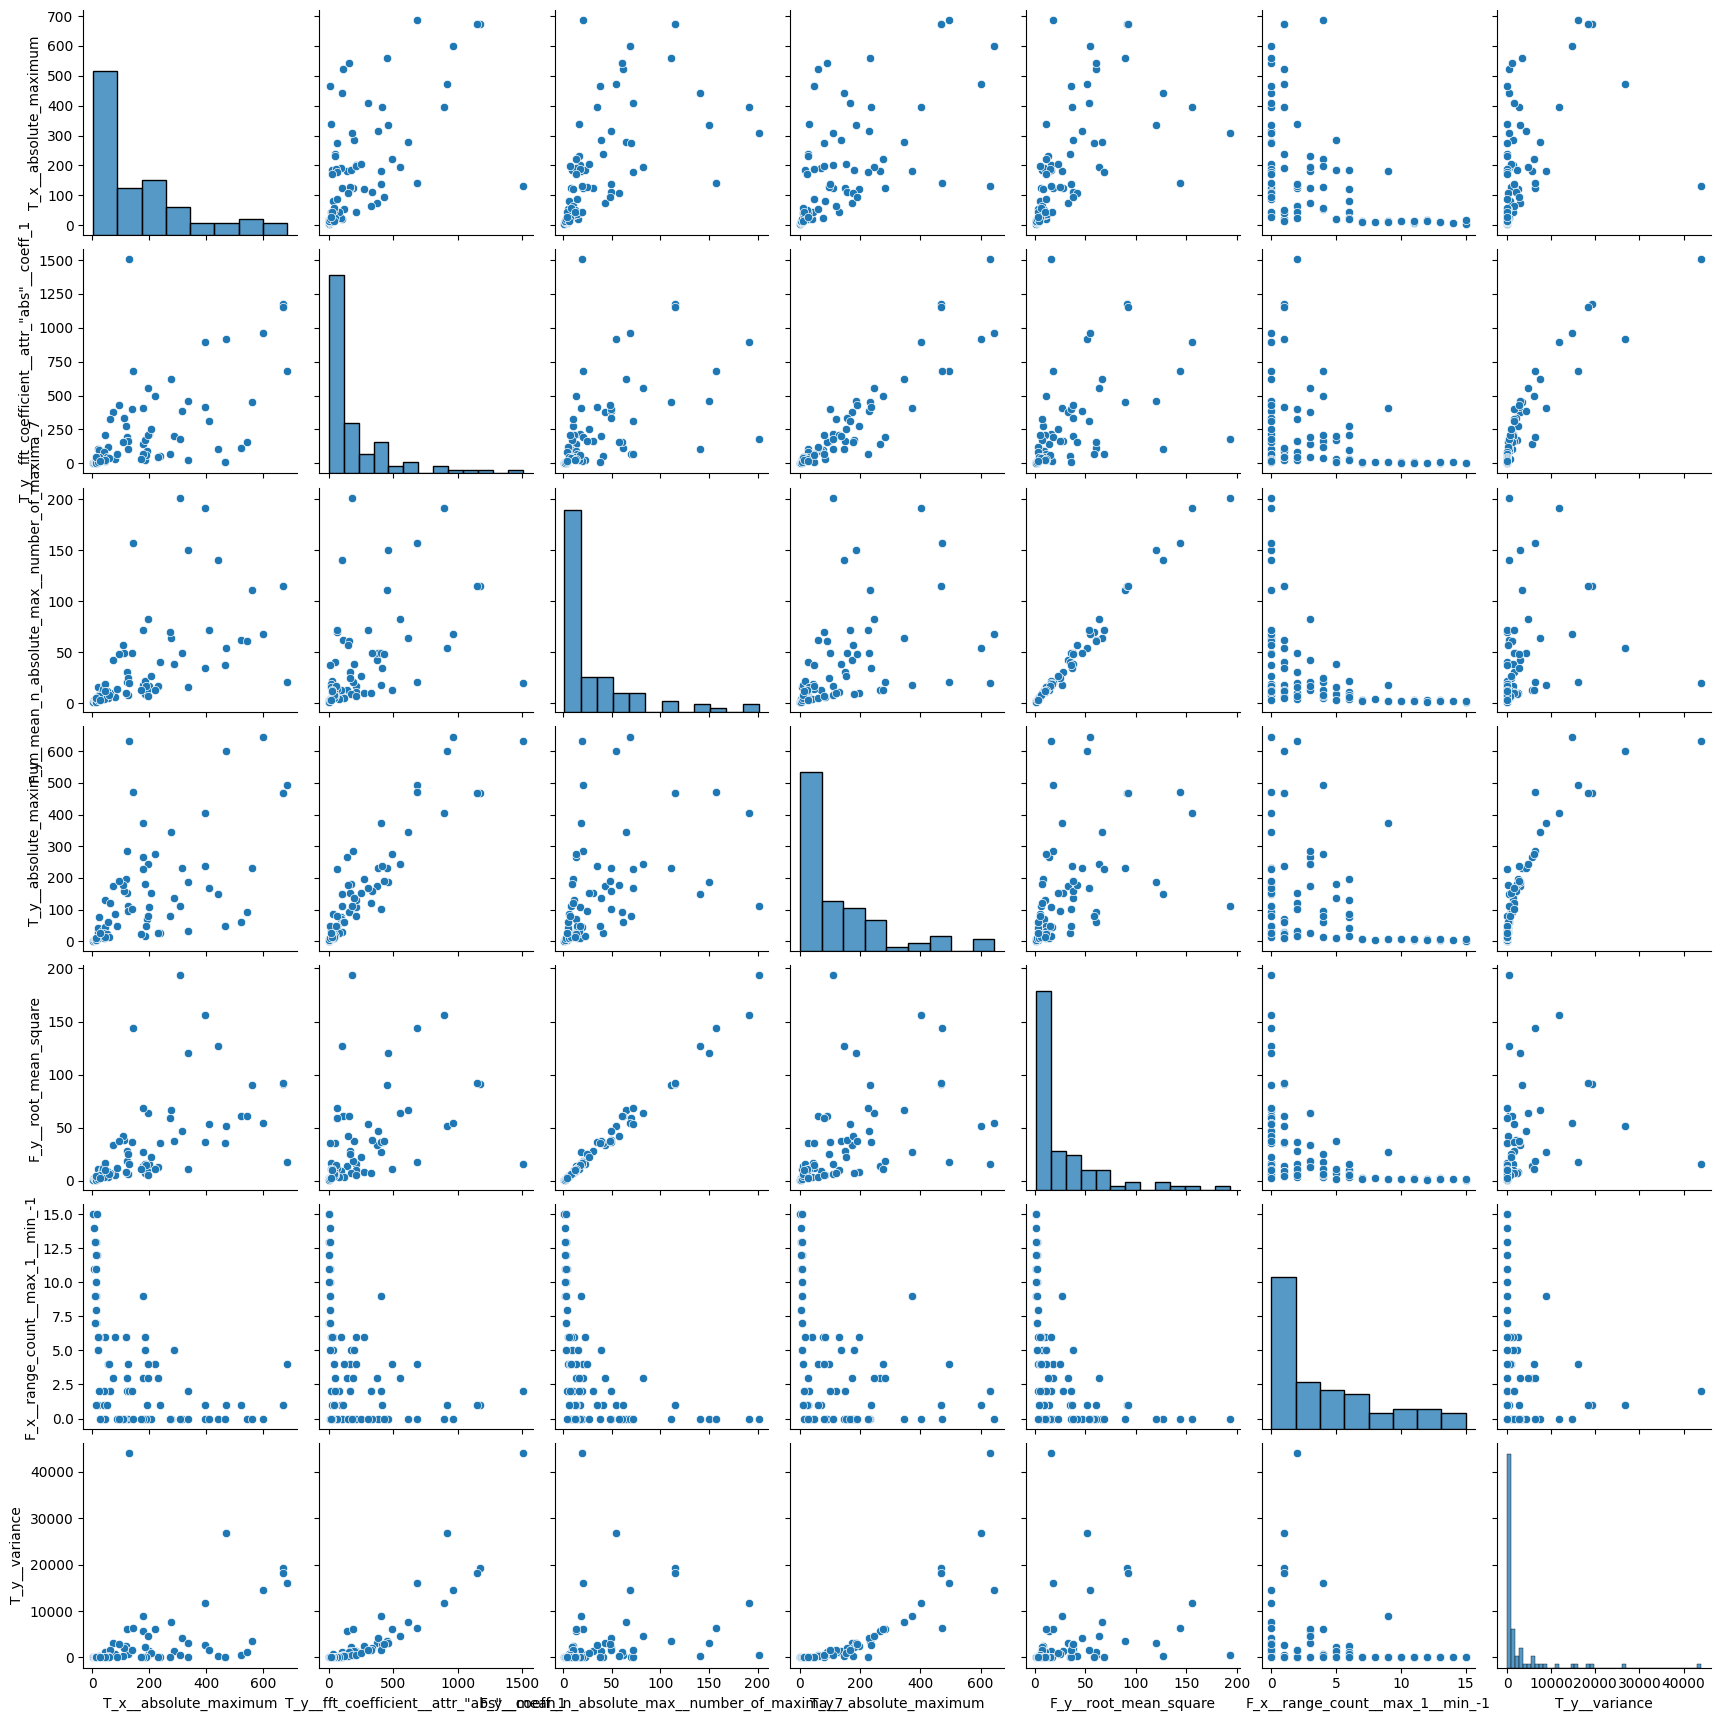

In [41]:
# Pairplot dla wybranych cech

data_corr = df_features_1.copy()
sns.pairplot(data_corr)

Obliczamy wsp. korelacji Spermana, ponieważ związek w większości przypadków jest monotoniczny i istnieje wiele wartości odstających.

In [42]:
data_corr.corr(method = 'spearman')

,T_x__absolute_maximum,"T_y__fft_coefficient__attr_""abs""__coeff_1",F_y__mean_n_absolute_max__number_of_maxima_7,T_y__absolute_maximum,F_y__root_mean_square,F_x__range_count__max_1__min_-1,T_y__variance
T_x__absolute_maximum,1.000000,0.764779,0.855188,0.803895,0.858701,-0.651994,0.768513
"T_y__fft_coefficient__attr_""abs""__coeff_1",0.764779,1.000000,0.780008,0.937854,0.785103,-0.547724,0.970501
F_y__mean_n_absolute_max__number_of_maxima_7,0.855188,0.780008,1.000000,0.798693,0.996768,-0.749786,0.758608
T_y__absolute_maximum,0.803895,0.937854,0.798693,1.000000,0.810036,-0.569944,0.956875
F_y__root_mean_square,0.858701,0.785103,0.996768,0.810036,1.000000,-0.746706,0.769305
F_x__range_count__max_1__min_-1,-0.651994,-0.547724,-0.749786,-0.569944,-0.746706,1.000000,-0.504100
T_y__variance,0.768513,0.970501,0.758608,0.956875,0.769305,-0.504100,1.000000


In [43]:
pg.pairwise_corr(data_corr, method='spearman')

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,T_x__absolute_maximum,"T_y__fft_coefficient__attr_""abs""__coeff_1",spearman,two-sided,88,0.764779,"[0.66, 0.84]",4.242627e-18,1.000000
1,T_x__absolute_maximum,F_y__mean_n_absolute_max__number_of_maxima_7,spearman,two-sided,88,0.855188,"[0.79, 0.9]",2.849838e-26,1.000000
2,T_x__absolute_maximum,T_y__absolute_maximum,spearman,two-sided,88,0.803895,"[0.71, 0.87]",4.165803e-21,1.000000
3,T_x__absolute_maximum,F_y__root_mean_square,spearman,two-sided,88,0.858701,"[0.79, 0.91]",1.071110e-26,1.000000
4,T_x__absolute_maximum,F_x__range_count__max_1__min_-1,spearman,two-sided,88,-0.651994,"[-0.76, -0.51]",5.961061e-12,1.000000
5,T_x__absolute_maximum,T_y__variance,spearman,two-sided,88,0.768513,"[0.67, 0.84]",2.324023e-18,1.000000
6,"T_y__fft_coefficient__attr_""abs""__coeff_1",F_y__mean_n_absolute_max__number_of_maxima_7,spearman,two-sided,88,0.780008,"[0.68, 0.85]",3.387399e-19,1.000000
7,"T_y__fft_coefficient__attr_""abs""__coeff_1",T_y__absolute_maximum,spearman,two-sided,88,0.937854,"[0.91, 0.96]",2.705829e-41,1.000000
8,"T_y__fft_coefficient__attr_""abs""__coeff_1",F_y__root_mean_square,spearman,two-sided,88,0.785103,"[0.69, 0.85]",1.389754e-19,1.000000
9,"T_y__fft_coefficient__attr_""abs""__coeff_1",F_x__range_count__max_1__min_-1,spearman,two-sided,88,-0.547724,"[-0.68, -0.38]",3.335632e-08,0.999908


ODP:

Widzimy, już że istnieją pary zmiennych silnie skorelowanych dlatego ze zbioru usuwamy te, które są zbędne, tak aby jak najbardziej ograniczyć zbiór. Ograniczając zbiór uwzględniamy również istotność cech.

**Wybrane cechy:**

T_x__absolute_maximum - najwyższa wartość bezwzględna szeregu czasowego,

F_x__range_count__max_1__min_-1 - zlicz zaobserwowane wartości w przedziale [min, max] - w naszym wypadku od -1 do 1,

T_y__fft_coefficient__attr_"abs"__coeff_1 - oblicza współczynniki Fouriera jednowymiarowej dyskretnej transformaty Fouriera dla rzeczywistych danych wejściowych za pomocą algorytmu szybkiej transformacji Fouriera - w tym wypadku jest to wartość bezwzględna 1 współczynnika.

**Sprawdzenie:**

In [44]:
df_features_1_1 = df_features_1[['T_x__absolute_maximum', 'F_x__range_count__max_1__min_-1', 'T_y__fft_coefficient__attr_"abs"__coeff_1']]

In [45]:
pg.pairwise_corr(df_features_1_1 , method='spearman')

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,T_x__absolute_maximum,F_x__range_count__max_1__min_-1,spearman,two-sided,88,-0.651994,"[-0.76, -0.51]",5.961061e-12,1.000000
1,T_x__absolute_maximum,"T_y__fft_coefficient__attr_""abs""__coeff_1",spearman,two-sided,88,0.764779,"[0.66, 0.84]",4.242627e-18,1.000000
2,F_x__range_count__max_1__min_-1,"T_y__fft_coefficient__attr_""abs""__coeff_1",spearman,two-sided,88,-0.547724,"[-0.68, -0.38]",3.335632e-08,0.999908


Narysujmy jeszcze raz wykresy:

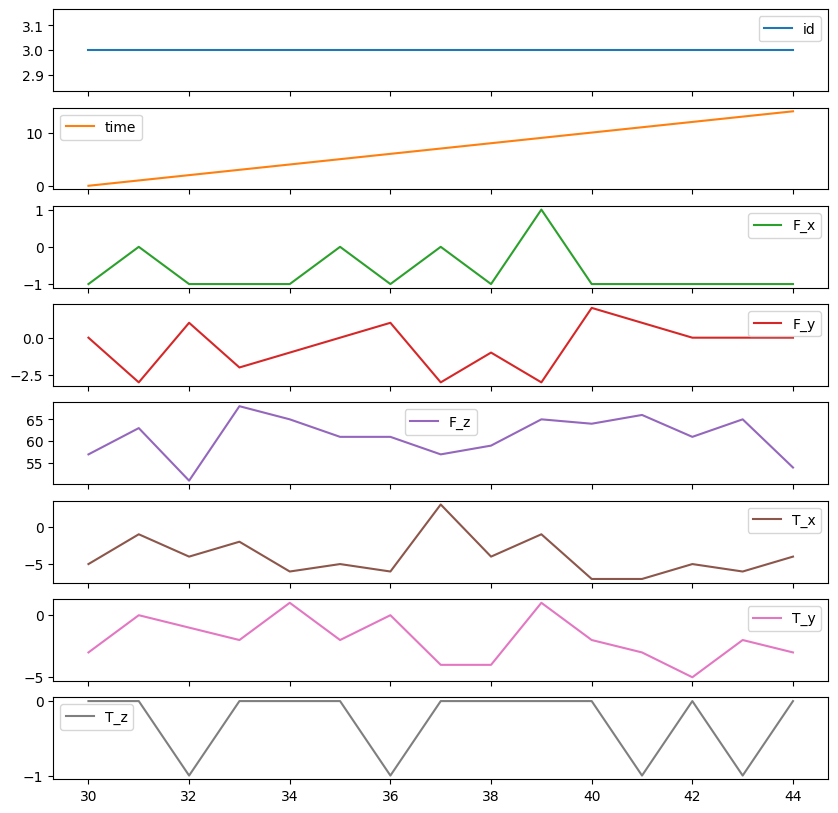

In [46]:
timeseries[timeseries['id'] == 3].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

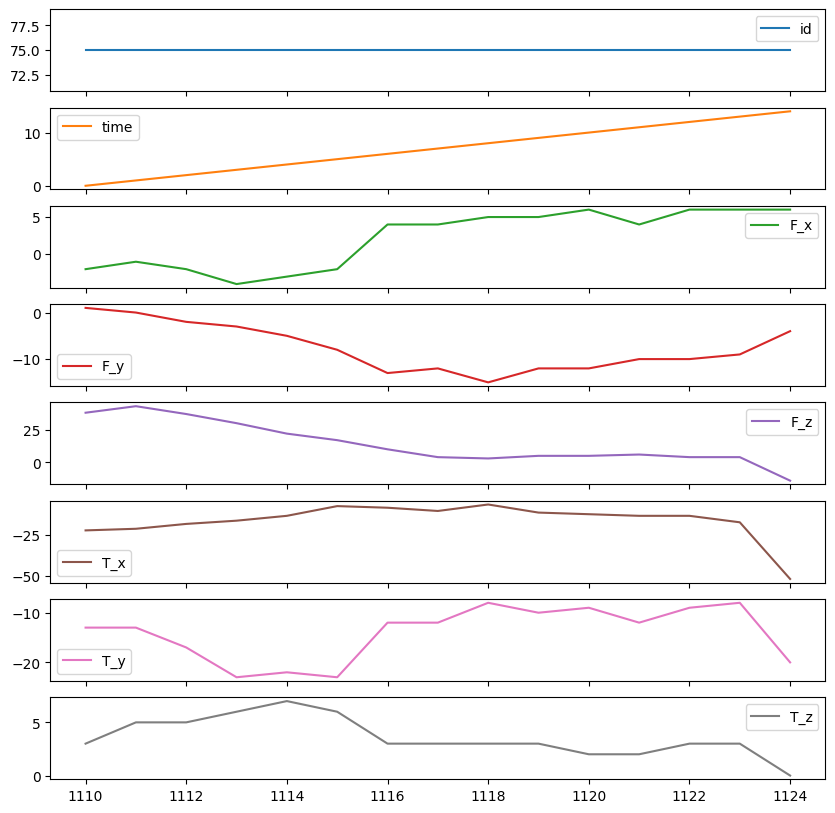

In [47]:
timeseries[timeseries['id'] == 75].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

Możemy zaobserwować, że wartości Fx w przypadku awarii znacząco odbiegają od skrajnej wartości -1, w przeciwieństwie do wartości Fx robota bez awarii, robot, który uległ awarii osiąga też znacznie więcej wartości powyżej 1 (F_x__range_count__max_1__min_-1). Tx osiąga znacznie wyższe wartości, gdy robot jest sprawny (T_x__absolute_maximum) - pozwala to wysunąć wniosek, że wybrane cechy faktycznie mogą okazać się bardzo istotne, aby prawidłowo określić stan robota.

Klasyfikacja przy wykorzystaniu lasu losowego:

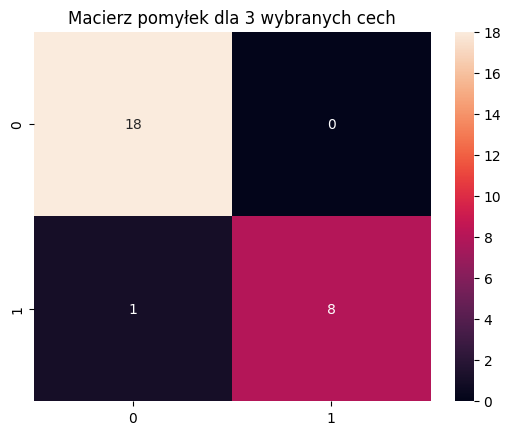

Raport klasyfikacji dla lasu losowego dla 3 wybranych cech:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97        18
        True       1.00      0.89      0.94         9

    accuracy                           0.96        27
   macro avg       0.97      0.94      0.96        27
weighted avg       0.96      0.96      0.96        27



In [48]:
# Podział danych na cechy (X) i etykietę (y)
X = df_features_1_1
y = y

# Podział na zestaw treningowy i testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla 3 wybranych cech')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego dla 3 wybranych cech:")
print(rf_classification_report_full)

Jak widzimy trzy zmienne w tym wypadku są wystarczające do bardzo dobrej klasyfikacji.

**Zadanie**

 Proszę wyznaczyć 15 cech najlepiej skorelowanych z wyjściem (y), a następnie przeprowadzić pełną analizę i klasyfikację.

Czy wyznaczone cechy są takie same?

In [50]:
# Rozwiązanie
X = features_filtered_2

cor_support, cor_feature = cor_selector(X, y, 15, type_corr = 's')
print(str(len(cor_feature)), 'selected features')

15 selected features


In [55]:
print(len(cor_support), cor_support)

375 [True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, Fa

In [56]:
print(len(cor_feature), cor_feature)

15 ['F_x__fft_coefficient__attr_"abs"__coeff_1', 'T_x__absolute_maximum', 'F_y__absolute_maximum', 'T_y__standard_deviation', 'T_y__variance', 'F_y__mean_n_absolute_max__number_of_maxima_7', 'F_y__root_mean_square', 'F_y__abs_energy', 'F_x__range_count__max_1__min_-1', 'F_x__mean_n_absolute_max__number_of_maxima_7', 'T_y__absolute_maximum', 'F_x__root_mean_square', 'F_x__abs_energy', 'F_x__variance_larger_than_standard_deviation', 'F_x__value_count__value_-1']


In [58]:
selected_features_df = extracted_features[cor_feature]

selected_features_df.head()

,"F_x__fft_coefficient__attr_""abs""__coeff_1",T_x__absolute_maximum,F_y__absolute_maximum,T_y__standard_deviation,T_y__variance,F_y__mean_n_absolute_max__number_of_maxima_7,F_y__root_mean_square,F_y__abs_energy,F_x__range_count__max_1__min_-1,F_x__mean_n_absolute_max__number_of_maxima_7,T_y__absolute_maximum,F_x__root_mean_square,F_x__abs_energy,F_x__variance_larger_than_standard_deviation,F_x__value_count__value_-1
1,1.000000,3.0,1.0,0.471405,0.222222,1.000000,0.930949,13.0,15.0,1.000000,1.0,0.966092,14.0,0.0,14.0
2,0.624118,10.0,4.0,2.054805,4.222222,3.000000,2.250926,76.0,13.0,1.571429,5.0,1.290994,25.0,0.0,7.0
3,2.203858,7.0,3.0,1.768867,3.128889,2.142857,1.632993,40.0,14.0,1.000000,5.0,0.894427,12.0,0.0,11.0
4,0.844394,15.0,5.0,2.669998,7.128889,2.428571,2.000000,60.0,10.0,1.285714,6.0,1.032796,16.0,0.0,5.0
5,2.730599,12.0,3.0,2.039608,4.160000,2.285714,1.751190,46.0,13.0,1.285714,5.0,1.064581,17.0,0.0,9.0


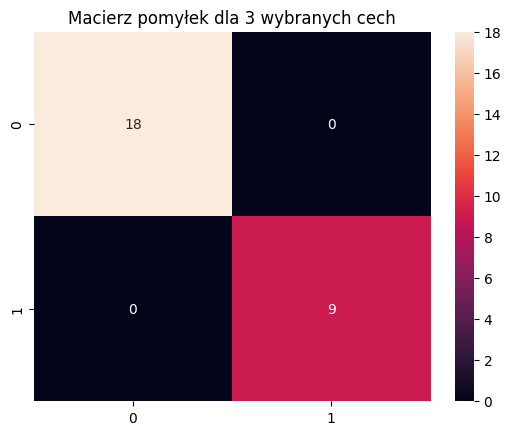

Raport klasyfikacji dla lasu losowego dla 3 wybranych cech:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        18
        True       1.00      1.00      1.00         9

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



In [59]:
X_train, X_test, y_train, y_test = train_test_split(selected_features_df, y, test_size=0.3, random_state=42)

# Standaryzacja cech
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Wytrenowanie klasyfikatora
rf_classifier_full = RandomForestClassifier(random_state=42)
rf_classifier_full.fit(X_train_scaled, y_train)

# Prognozy i metryki
rf_predictions_full = rf_classifier_full.predict(X_test_scaled)
rf_confusion_matrix_full = confusion_matrix(y_test, rf_predictions_full)
rf_classification_report_full = classification_report(y_test, rf_predictions_full)

# Wizualizacja macierzy pomyłek
sns.heatmap(rf_confusion_matrix_full, annot=True, fmt="d")
plt.title('Macierz pomyłek dla 3 wybranych cech')
plt.show()

# Wyświetlenie raportu klasyfikacji
print("Raport klasyfikacji dla lasu losowego dla 3 wybranych cech:")
print(rf_classification_report_full)